In [1]:
import os
import torch
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

c:\Users\mmocak\PycharmProjects\machine-learning-circus\.venv\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import subgraph

citeseer_dataset = Planetoid(root = "Citeseer_dataset", name = "Citeseer", transform = NormalizeFeatures())

In [3]:
data = citeseer_dataset[0]

# Create a mask for nodes whose label is either 0 or 1
mask = (data.y == 0) | (data.y == 1)
filtered_node_indices = mask.nonzero(as_tuple=False).view(-1)

# Extract the subgraph that contains only the filtered nodes. 
# The parameter relabel_nodes=True updates node indices accordingly.
edge_index, edge_attr = subgraph(filtered_node_indices, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes)

# Create a new data object for the filtered graph
filtered_data = data.__class__()
filtered_data.x = data.x[filtered_node_indices]
filtered_data.y = data.y[filtered_node_indices]
filtered_data.edge_index = edge_index
if hasattr(data, 'edge_attr') and data.edge_attr is not None:
    filtered_data.edge_attr = edge_attr

num_nodes = filtered_data.num_nodes
torch.manual_seed(42)
indices = torch.randperm(num_nodes)

train_end = int(0.6 * num_nodes)
val_end = int(0.8 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_end]] = True
val_mask[indices[train_end:val_end]] = True
test_mask[indices[val_end:]] = True

filtered_data.train_mask = train_mask
filtered_data.val_mask = val_mask
filtered_data.test_mask = test_mask


filtered_citeseer_dataset = filtered_data


In [4]:
print(len(citeseer_dataset))
print(citeseer_dataset.num_classes)
print(citeseer_dataset.num_features)
citeseer_graph = filtered_citeseer_dataset
citeseer_graph

1
6
3703


Data(x=[854, 3703], y=[854], edge_index=[2, 1320], train_mask=[854], val_mask=[854], test_mask=[854])

In [5]:
#citeseer_graph.x

In [6]:
print("Training samples: ", citeseer_graph.train_mask.sum().item())
print("Validation samples: ", citeseer_graph.val_mask.sum().item())
print("Test samples: ", citeseer_graph.test_mask.sum().item())

Training samples:  512
Validation samples:  171
Test samples:  171


In [7]:
# citeseer_graph.y

In [8]:
print(f'Number of nodes: {citeseer_graph.num_nodes}')
print(f'Number of edges: {citeseer_graph.num_edges}')
print(f'Average node degree: {citeseer_graph.num_edges / citeseer_graph.num_nodes:.2f}')
print(f'Has isolated nodes: {citeseer_graph.has_isolated_nodes()}')
print(f'Has self-loops: {citeseer_graph.has_self_loops()}')
print(f'Is undirected: {citeseer_graph.is_undirected()}')

Number of nodes: 854
Number of edges: 1320
Average node degree: 1.55
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [9]:
# Extract features (X) and labels (y)
X = citeseer_graph.x.cpu().numpy()
y = citeseer_graph.y.cpu().numpy()

# Split data into train, validation, and test sets
train_mask = citeseer_graph.train_mask.cpu().numpy()
val_mask = citeseer_graph.val_mask.cpu().numpy()
test_mask = citeseer_graph.test_mask.cpu().numpy()

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

In [10]:
# Combine train and validation sets for XGBoost training
X_train_combined = torch.cat([torch.tensor(X_train), torch.tensor(X_val)]).numpy()
y_train_combined = torch.cat([torch.tensor(y_train), torch.tensor(y_val)]).numpy()

In [11]:
# Train an XGBoost classifier
model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=2,
    eval_metric="mlogloss",
    use_label_encoder=False,
    learning_rate=0.01,
    max_depth=6,
    n_estimators=500
)

In [12]:
model.fit(X_train_combined, y_train_combined)

c:\Users\mmocak\PycharmProjects\machine-learning-circus\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:44:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=2, num_parallel_tree=None, ...)

In [13]:
# Evaluate on the test set
y_pred = model.predict(X_test)

In [14]:
#y_pred

In [15]:
# Define label names and colors
label_dict = {
    0: "Agents",
    1: "AI"
}


In [16]:
# Evaluate on the test set
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

# Now compute accuracy_score and display predictions
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.3f}")

# Display predictions for the first 10 nodes
print("Predictions for the first 10 nodes in the test set:")
for i in range(10):
    print(f"Node {i}: Predicted={label_dict[y_pred[i]]}, Actual={label_dict[y_test[i]]}")

Test Accuracy: 0.789
Predictions for the first 10 nodes in the test set:
Node 0: Predicted=AI, Actual=AI
Node 1: Predicted=AI, Actual=AI
Node 2: Predicted=AI, Actual=AI
Node 3: Predicted=AI, Actual=AI
Node 4: Predicted=AI, Actual=AI
Node 5: Predicted=AI, Actual=AI
Node 6: Predicted=AI, Actual=Agents
Node 7: Predicted=Agents, Actual=Agents
Node 8: Predicted=Agents, Actual=Agents
Node 9: Predicted=AI, Actual=Agents


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

AUC: 0.772


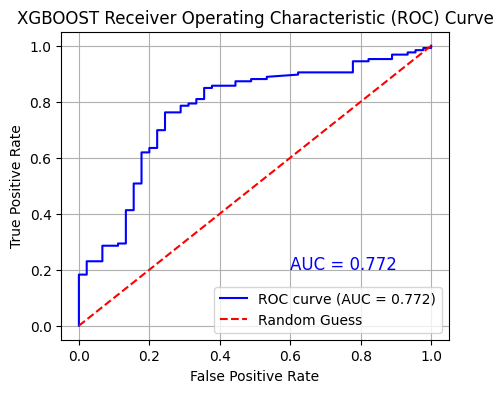

In [18]:
# Compute probabilities for the test set

# probs = model.predict_proba(citeseer_graph).cpu().detach().numpy()

# Extract node features from the torch_geometric.data.Data object
node_features = citeseer_graph.x.cpu().detach().numpy()

# Use the extracted features with XGBClassifier
probs = model.predict_proba(node_features)

y_test = citeseer_graph.y[citeseer_graph.test_mask].cpu().numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs[citeseer_graph.test_mask, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBOOST Receiver Operating Characteristic (ROC) Curve')

# add AUC score to the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc:.3f}', fontsize=12, color='blue')

# print the AUC value
print(f'AUC: {roc_auc:.3f}')

plt.legend(loc='lower right')
plt.grid()
plt.show()

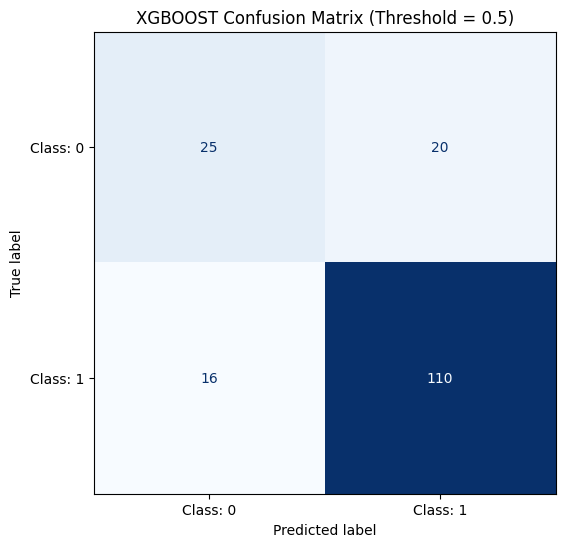

In [19]:
# Define an arbitrary threshold
threshold = 0.5

# Compute predictions based on the threshold
y_pred = (probs[citeseer_graph.test_mask, 1] >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix

# Create a new figure and axes with the desired size
fig, ax = plt.subplots(figsize=(8, 6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class: 0", "Class: 1"])
disp.plot(ax=ax,cmap=plt.cm.Blues, colorbar=False)
plt.title(f'XGBOOST Confusion Matrix (Threshold = {threshold})')
plt.show()